In [1]:
script = False
cluster = False

import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
plt.style.use('dark_background')
import random
import copy
from distutils.util import strtobool

if(script): 
    from tqdm import tqdm
else:
    from tqdm.notebook import tqdm
    import ipython_bell

from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from astropy.visualization import make_lupton_rgb

import lenstronomy.Util.param_util as param
import lenstronomy.Util.util as util
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver

import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
DES_camera = {'read_noise': 7.,  # std of noise generated by read-out (in units of electrons)
               'pixel_scale': 0.2637,  # scale (in arcseconds) of pixels
               'ccd_gain': 6.  # electrons/ADU (analog-to-digital unit). A gain of 8 means that the camera digitizes the CCD signal so that each ADU corresponds to 8 photoelectrons.
              }

DES_g_band_obs = {'exposure_time': 90.,  # exposure time per image (in seconds)
                   'sky_brightness': 35.01,  # sky brightness (in magnitude per square arcseconds)
                   'magnitude_zero_point': 30,  # magnitude in which 1 count per second per arcsecond square is registered (in ADU's)
                   'num_exposures': 7,  # number of exposures that are combined
                   'seeing': 1.12,  # full width at half maximum of the PSF (if not specific psf_model is specified)
                   'psf_type': 'GAUSSIAN',  # string, type of PSF ('GAUSSIAN' and 'PIXEL' supported)
                   'kernel_point_source': None  # 2d numpy array, model of PSF centered with odd number of pixels per axis (optional when psf_type='PIXEL' is chosen)
                  }

DES_r_band_obs = {'exposure_time': 90.,  
                   'sky_brightness': 34.7,  
                   'magnitude_zero_point': 30,  
                   'num_exposures': 7,  
                   'seeing': 1.12,  
                   'psf_type': 'GAUSSIAN', 
                  }

DES_i_band_obs = {'exposure_time': 90.,  
                   'sky_brightness': 35.1,  
                   'magnitude_zero_point': 30,  
                   'num_exposures': 7,  
                   'seeing': 1.12,  
                   'psf_type': 'GAUSSIAN', 
                  }

numpix = 45 # 

kwargs_g_band = util.merge_dicts(DES_camera, DES_g_band_obs)
kwargs_r_band = util.merge_dicts(DES_camera, DES_r_band_obs)
kwargs_i_band = util.merge_dicts(DES_camera, DES_i_band_obs)

kwargs_numerics = {'point_source_supersampling_factor': 10}

cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)

In [3]:
def make_graphs(name, sim_i, sim_r, sim_g, cutout_i, cutout_r, cutout_g):
    loc = plticker.MultipleLocator(base=3.75)
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 4), ncols=3)

    rgb = make_lupton_rgb(sim_i, sim_r, sim_g, Q=11., stretch=40.)
    ax1.set_title('Source(s)')
    ax1.xaxis.set_ticklabels([])
    ax1.yaxis.set_ticklabels([])
    original = ax1.imshow(rgb, aspect='equal')

    rgb = make_lupton_rgb(cutout_i, cutout_r, cutout_g, Q=11., stretch=40.)
    ax2.set_title('Lens')
    ax2.xaxis.set_ticklabels([])
    ax2.yaxis.set_ticklabels([])
    cutout = ax2.imshow(rgb, aspect='equal')
            
    rgb = make_lupton_rgb(sim_i+cutout_i, sim_r+cutout_r, sim_g+cutout_g, Q=11., stretch=40.)
    ax3.set_title('Complete Simulation')
    ax3.xaxis.set_ticklabels([])
    ax3.yaxis.set_ticklabels([])
    projection = ax3.imshow(rgb, aspect='equal')
   
    sub_path = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/'
    #plt.savefig(sub_path + 'Data/Sim_complete/Image' + name + '.png', bbox_inches='tight')
    plt.show()


In [4]:
# Writes fit file
def write_fit_file(name, x, data):
    my_types = {'Y6_COADD_OBJECT_ID': int, 'TILENAME': str, 'HPIX_16384': int, 'HPIX_4096': int,
       'DNF_ZMEAN_SOF': float, 'RA': float, 'DEC': float, 'FLUX_RADIUS_G': float, 'FLUX_RADIUS_R': float,
       'FLUX_RADIUS_I': float, 'FLUX_RADIUS_Z': float, 'KRON_RADIUS': float, 'GAP_FLUX_G': float,
       'MOF_BDF_FLUX_G': float, 'MOF_PSF_FLUX_G': float, 'SOF_BDF_FLUX_G': float, 'SOF_PSF_FLUX_G': float,
       'MAG_AUTO_G': float, 'MAG_APER_4_G': float, 'MAG_APER_8_G': float, 'SOF_BDF_G_1': float,
       'Y3_COADD_OBJECT_ID': int, 'REFMAG': float, 'REFMAG_ERR': float, 'LUM': float, 'ZREDMAGIC': float,
       'ZREDMAGIC_E': float, 'CHISQ': float, 'Z_LENS': float, 'MAG_G': float, 'MAG_R': float, 'MAG_I': float, 'MAG_Z': float,
       'MAG_ERR_G': float, 'MAG_ERR_R': float, 'MAG_ERR_I': float, 'MAG_ERR_Z': float, 'ZG': float, 'ZR': float, 'ZI': float,
       'ZZ': float, 'SOF_BDF_G_2': float, 'IMAFLAGS_ISO_G': int, 'IMAFLAGS_ISO_R': int,
       'IMAFLAGS_ISO_I': int, 'IMAFLAGS_ISO_Z': int, 'EXT_COADD': int, 'FWHM_WMEAN_G': float,
       'FWHM_WMEAN_R': float, 'FWHM_WMEAN_I': float, 'FWHM_WMEAN_Z': float, 'SKYBRITE_WMEAN_G': float,
       'SKYBRITE_WMEAN_R': float, 'SKYBRITE_WMEAN_I': float, 'SKYBRITE_WMEAN_Z': float, 'Z1': float, 'LENSED_MAG': float,     
       'mag_1': float, 'ISOLATION': float, 'EINSTEIN_RADIUS': float, 'MAGNIFICATION': float}
    data = data.astype(my_types)
    
    primary = fits.PrimaryHDU()
    image = fits.ImageHDU(x, name="IMAGE")
    table_data = Table.from_pandas(data)
    table = fits.BinTableHDU(data = table_data)
    hdu_list = fits.HDUList([primary, image, table])
    hdu_list.writeto(file_path + name + '.fits', overwrite=True)   
    hdu_list.close()


In [5]:
# Function to pick a position very close to the caustic
def pick_center(ra_caustic_list, dec_caustic_list):
    l = random.randint(0, len(ra_caustic_list)-1)
    noise_ra, noise_dec = random.uniform(-0.75, 0.75), random.uniform(-0.75, 0.75)
    return(ra_caustic_list[l] + noise_ra, dec_caustic_list[l] + noise_dec)

def distribution(z, data):
    dz = 0.1 # Range of redshift for filtering
    new_data = data[data['DNF_ZMEAN_SOF'] > z - dz] [data['DNF_ZMEAN_SOF'] < z + dz] 
    new_data = new_data[new_data['MAG_PSF_G'] < MMAX]
    random_object = new_data.sample()
    mg, mr, mi = random_object['MAG_PSF_G'].values[0], random_object['MAG_PSF_R'].values[0], random_object['MAG_PSF_I'].values[0]
    rg, rr, ri = random_object['FLUX_RADIUS_G'].values[0], random_object['FLUX_RADIUS_R'].values[0], random_object['FLUX_RADIUS_I'].values[0]
    e1, e2 = random_object['SOF_CM_G_1'].values[0], random_object['SOF_CM_G_2'].values[0]
    magnitude = {'mg': mg, 'mr': mr, 'mi': mi}
    radius = {'rg': rg*DES_camera['pixel_scale'], 'rr': rr*DES_camera['pixel_scale'], 'ri': ri*DES_camera['pixel_scale']}
    ellipticity = {'e1': e1, 'e2': e2}
    return(magnitude, radius, ellipticity)

def distribution_data(path):
    data_dist = pd.read_csv(path)
    data_dist = data_dist[data_dist['MAG_PSF_G'] < 30.] [data_dist['MAG_PSF_R'] < 30.] [data_dist['MAG_PSF_I'] < 30.]
    data_dist = data_dist[data_dist['SOF_CM_G_1'] > -100.][data_dist['SOF_CM_G_2'] > -100.]
    data_dist = data_dist[data_dist['DNF_ZMEAN_SOF'] > 0.01][data_dist['DNF_ZMEAN_SOF'] < 2.9]
    data_dist = data_dist.sort_values('DNF_ZMEAN_SOF').reset_index()
    return(data_dist)

In [6]:
def simulation(model, redshifts, lens_image, lens, cuts, additional_info):
   
    kwargs_model_physical = {'lens_model_list': ['SIE'],  # list of lens models to be used
                          'lens_redshift_list': [redshifts['lens']],  # list of redshift of the deflections
                             #'lens_light_model_list': ['SERSIC_ELLIPSE'],
                          # list of extended source models to be used
                          'source_light_model_list': ['SERSIC_ELLIPSE'],  
                          # list of redshfits of the sources in same order as source_light_model_list
                          'source_redshift_list': [redshifts['source1']],  
                          'cosmo': cosmo,  # astropy.cosmology instance
                          # redshift of the default source (if not further specified by 'source_redshift_list')
                          'z_source': redshifts['source1']} 
                           #and also serves as the redshift of lensed point sources}
        
    sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model_physical)
    sim_r = SimAPI(numpix=numpix, kwargs_single_band=kwargs_r_band, kwargs_model=kwargs_model_physical)
    sim_i = SimAPI(numpix=numpix, kwargs_single_band=kwargs_i_band, kwargs_model=kwargs_model_physical)
    
    imSim_g = sim_g.image_model_class(kwargs_numerics)
    imSim_r = sim_r.image_model_class(kwargs_numerics)
    imSim_i = sim_i.image_model_class(kwargs_numerics)

    #lens mass model
    kwargs_mass = [{'sigma_v': lens['sigma'], 'center_x': 0, 'center_y': 0, 
                    'e1': lens['e1'], 'e2': lens['e2']}]
    kwargs_lens = sim_g.physical2lensing_conversion(kwargs_mass=kwargs_mass)
    
    #caustics and critical curves
    ra_crit_list, dec_crit_list, ra_caustic_list, dec_caustic_list = model['model_ext'].critical_curve_caustics(kwargs_lens, 
                                                                compute_window=15, grid_scale=0.01, center_x=0, center_y=0)
    if(len(ra_caustic_list)==0): return('No caustics')
    ra_caustic_list, dec_caustic_list = ra_caustic_list[0], dec_caustic_list[0]
    
    #cut on the Einstein radius of the lens
    if(kwargs_lens[0]['theta_E'] < cuts['E_min'] or kwargs_lens[0]['theta_E'] > cuts['E_max']):
        return ('No cut E: {:.3f}'.format(kwargs_lens[0]['theta_E']))
    
    
    #First source light distributions & colors of the other bands for each source
    mag1, rad1, ellip1 = distribution(redshifts['source1'], data = data_dist)
    n1 = random.uniform(0.3, 4.)
    #Pick center of first source on the caustic
    c1x, c1y = pick_center(ra_caustic_list, dec_caustic_list)
    theta_ra1, theta_dec1 = model['solver'].image_position_from_source(c1x, c1y, kwargs_lens)
    
    #First source light:
    kwargs_source_mag_g = [{'magnitude': mag1['mg'], 'R_sersic': rad1['rg'], 'n_sersic': n1,
                              'e1': ellip1['e1'], 'e2': ellip1['e2'], 'center_x': c1x, 'center_y': c1y}]
    #Adding color distribution to the bands (first source):
    kwargs_source_mag_r = copy.deepcopy(kwargs_source_mag_g)
    kwargs_source_mag_r[0]['magnitude'], kwargs_source_mag_r[0]['R_sersic'] = mag1['mr'], rad1['rr']
    kwargs_source_mag_i = copy.deepcopy(kwargs_source_mag_g)
    kwargs_source_mag_i[0]['magnitude'], kwargs_source_mag_i[0]['R_sersic'] = mag1['mi'], rad1['ri']
    
    kwargs_lens_light_g, kwargs_source_g , point = sim_g.magnitude2amplitude(kwargs_lens_light_mag=None, 
                                                    kwargs_source_mag=kwargs_source_mag_g, kwargs_ps_mag=None)
    kwargs_lens_light_r, kwargs_source_r , point = sim_r.magnitude2amplitude(kwargs_lens_light_mag=None, 
                                                    kwargs_source_mag=kwargs_source_mag_r, kwargs_ps_mag=None)
    kwargs_lens_light_i, kwargs_source_i , point = sim_i.magnitude2amplitude(kwargs_lens_light_mag=None, 
                                                    kwargs_source_mag=kwargs_source_mag_i, kwargs_ps_mag=None)
    
    image_g = imSim_g.image(kwargs_lens, kwargs_source_g)
    image_r = imSim_r.image(kwargs_lens, kwargs_source_r)
    image_i = imSim_i.image(kwargs_lens, kwargs_source_i)
    
    image_g += sim_g.noise_for_model(model=image_g)
    image_r += sim_r.noise_for_model(model=image_r)
    image_i += sim_i.noise_for_model(model=image_i)
    
    image_g = image_g[::-1]
    image_r = image_r[::-1]
    image_i = image_i[::-1]
    
    if(np.isnan(np.sum(image_g))): 
        return('IS NAN!!!!!')
    
    lens_g, lens_r, lens_i = lens_image[0], lens_image[1], lens_image[2]
    
    parameters = {'Z1': redshifts['source1'], 'mag_1': mag1['mg'],
                  'EINSTEIN_RADIUS': kwargs_lens[0]['theta_E']}
    
    tmp_series = pd.Series(parameters)
    #additional_info = pd.concat([additional_info, tmp_series])
    #df_test = pd.DataFrame(additional_info).transpose()
    df_test = pd.DataFrame(tmp_series).transpose()
    parameters = df_test #pd.DataFrame.from_dict(parameters)
    
    ele_sim = np.array([image_g + lens_g, image_r + lens_r, image_i + lens_i])
    
    print(kwargs_lens[0]['theta_E'])
    if(not script):
        make_graphs('example_simulations', image_i, image_r, image_g, lens_i, lens_r, lens_g)
        
    return ('ok', ele_sim, parameters)

In [7]:
def create_simulations(num, complete_data, lenses):
    num_sim = 0
    images_sim = np.zeros((1,3,45,45))
    data_sim = pd.DataFrame()

    lens_model_list = ['SIE']
    lensModel = LensModel(lens_model_list=lens_model_list)
    lensModelExt = LensModelExtensions(lensModel)
    solver = LensEquationSolver(lensModel)
    
    model = {'lensModel': lensModel, 'model_ext': lensModelExt, 'solver': solver}
    
    with tqdm(total=num) as pbar:
        while (num_sim < num):
            l = random.randint(0, len(complete_data)-1)
            row = complete_data.iloc[l]
            lens_image = lenses[l]
            
            DES_g_band_obs['seeing'] = row['FWHM_WMEAN_G'] 
            DES_r_band_obs['seeing'] = row['FWHM_WMEAN_R']
            DES_i_band_obs['seeing'] = row['FWHM_WMEAN_I']

            coadd_id = int(row['Y6_COADD_OBJECT_ID'])
            z_lens = random.uniform(0.2, 0.6)
            z1_max = random.uniform(0.65, 1.2) #0.2, 1.2   0.8 for DSPL
            z_source1 = random.uniform(z_lens + 0.05, z_lens + z1_max) # 1.2
            
            redshifts = {'lens': z_lens, 'source1': z_source1}
            
            e1, e2 = random.uniform(0., 0.5), random.uniform(0., 0.5)
            lens = {'sigma': random.uniform(300, 650), 'e1': e1, 'e2': e2}
            
            status = simulation(model, redshifts, lens_image, lens, cuts, row)
            
            if(status[0] == 'ok'):
                ele_sim, parameters = status[1], status[2]
                images_sim = np.append(images_sim, [ele_sim], axis = 0)
                data_sim = data_sim.append(parameters, ignore_index=True)
                num_sim += 1
                pbar.update(1)
                
    images_sim = np.delete(images_sim, 0, axis = 0)
    return(images_sim, data_sim)

In [8]:
def run_everything(num_sim, name_file):

    hdu_list = fits.open(lenses_path)
    lenses = hdu_list[1].data 
    complete_data = hdu_list[2].data[:]
    complete_data = Table(complete_data)
    complete_data = complete_data.to_pandas()
    complete_data = complete_data.rename({'ZSPEC': 'Z_LENS'}, axis=1)
    print(len(complete_data))
    hdu_list.close()

    images_sim, data_sim = create_simulations(num_sim, complete_data, lenses)
    write_fit_file(name_file, images_sim, data_sim)

In [9]:
ini_path = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/'
path_dist = ini_path + 'Data/source_distributions.csv'
lenses_path = ini_path + 'Data/Sim_complete/new_all_redmagic/' + 'all_redmagic_final.fits'
file_path = ini_path + 'Data/Sim_complete/exp/'

if(cluster):
    path_dist = 'source_distributions.csv'
    lenses_path = 'all_redmagic_final.fits' #'lenses_cutouts.fits'
    file_path = ''

data_dist = distribution_data(path_dist)
MMAX = 24.7
mmin, mmax, E_min, E_max, iso_min, iso_max, magni_min, magni_max = 17, 22.9, 0.4, 6.6, 0.7, 1000, 3.15, 1000
theta_E_r_f_min, theta_E_r_f_max = 0.2, 5.
cuts = {'E_max': E_max, 'E_min': E_min, 'mmax': mmax, 'mmin': mmin, 'iso_min': iso_min, 'iso_max': iso_max,
               'magni_min': magni_min, 'magni_max': magni_max, 'theta_E_r_f_min': theta_E_r_f_min, 
                'theta_E_r_f_max': theta_E_r_f_max}

50380


  0%|          | 0/2 [00:00<?, ?it/s]

0.6229229897332882


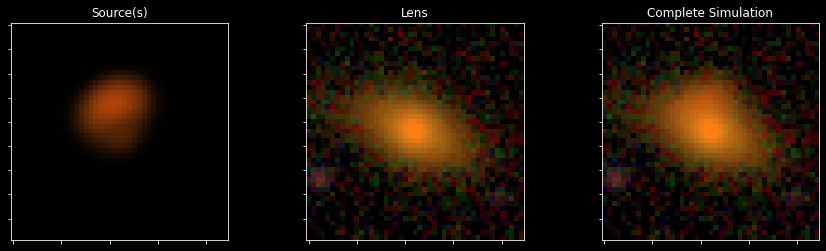

5.3889998795789635


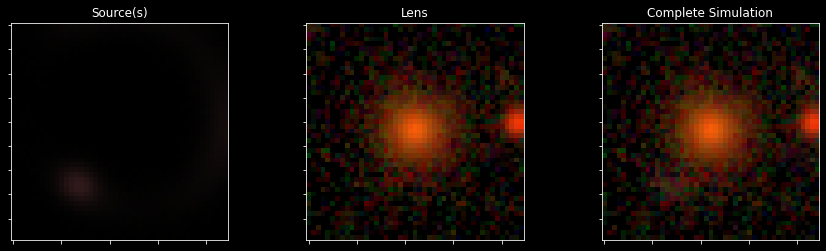

KeyError: 'Only a column name can be used for the key in a dtype mappings argument.'

In [10]:
run_everything(2, 'other')